# Predicting Employee Productivity Using Tree Models

## Introduction

Decision trees is a type of machine learning that is useful and easy to explain to non-techy audiences. In this project, we'll be introducing the dataset Productivity Prediction of Garment Employees. The original dataset is in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees).

The garment industry is a highly labour-intensive industry. Thus, it is crucial for the decision-makes in the industry to track, analyze, and predict the productivity performance of the workers.

The structure of this project is different than others in that **I'll first show and explain the tree, and the explanations for the data cleaning will be at the end of the project.**

## Importing and Cleaning the data

Let's quickly import and clean our data. As I said, the explanations for the changes below will be explained at the last chapter of the project.

In [53]:
import pandas as pd
file = pd.read_csv("C:/DATABASES/garments_worker_productivity.csv")
file_original = file.copy()

In [54]:
file.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [55]:
file.loc[file["department"] == "finishing ", "department"] = "finishing"
file.loc[file["quarter"] == "Quarter5", "quarter"] = "Quarter4"

file["no_of_workers"] = file["no_of_workers"].astype("int")
file["actual_productivity"] = file["actual_productivity"].round(2)

file["productive"] = file["actual_productivity"] >= file["targeted_productivity"]

file = file[["quarter", "day", "department", "team", "no_of_workers", "targeted_productivity", 
        "actual_productivity", "productive", "over_time", "smv", "incentive"]]

file["department"].replace({"finishing": 0, "sweing": 1}, inplace = True)
file.rename(columns = {"department": "dept_sweing"}, inplace = True)
file.rename(columns = {"smv": "std_minute_value"}, inplace = True)

file = pd.concat([file, pd.get_dummies(file["quarter"], prefix = "q")], axis = 1).drop(["quarter"], axis = 1)

file = pd.concat([file, pd.get_dummies(file["day"], prefix= None)], axis=1).drop(["day"], axis=1)

file = pd.concat([file, pd.get_dummies(file["team"], prefix= "team")], axis=1).drop(["team"], axis=1)

C:\Users\ETERNALPUPPY\AppData\Local\Temp\ipykernel_18892\3019790949.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  file["department"].replace({"finishing": 0, "sweing": 1}, inplace = True)
C:\Users\ETERNALPUPPY\AppData\Local\Temp\ipykernel_18892\3019790949.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcas

## Exploring the Data

Let's check out the original dataset to better understand our data. Here are the first five rows.

In [56]:
file_original.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


The following is the dataset's official column information. I'll only include the obscure and/or relevant ones:
- team: associated team number with the instance
- targeted_productivity: targeted productivity set by the authority for each team for each day
- smv: standard minute value — the allocated time for a task
- wip: work in progress — includes the number of unfinished items for products
- over_time: represents the amount of overtime by each team in minutes
- incentive: represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action
- idle_time: the duration of time when the production was interrupted due to several reasons
- idle_men: the number of workers who were idle due to production interruption
- no_of_style_change: number of changes in the style of a particular product
- no_of_workers: number of workers on each team
- actual_productivity: the actual % of productivity that was delivered by the workers — it ranges from 0 to 1.

We'll now build the tree and talk about the findings.

## Building the Tree

Since we are building a classification tree and not a regression tree, our target column "actual_productivity" must be categorical, not numerical. To accomplish this, we created a new column called "productive". It features boolean values ("True" or "False") indicating if the productivity targets were achieved for each observation in the dataset. Using this as the target column, we'll train our algorithm.

As a quick summary, the way we do it is that we create X (features / relevant columns) and y (target) variables and then divide the data into two; training set and test set. We train the algorithm with the train set and create predictions with the test set to see how well it can predict the y column in the test dataset. So, our algorithm is trained with features and target data of the train set, then it looks at the features of the test set and finally, it tries to predict target values with the given features.

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [58]:
# Feature and target columns

X = file.drop(["actual_productivity", "productive"], axis = 1)
y = file["productive"]

In [59]:
# Dividing in training and test sets with train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 24)

In [60]:
# Instantiating and fitting the Decision Tree Classifier

tree = DecisionTreeClassifier(max_depth = 3, random_state = 24)

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=24)

To ensure that the visualization of our Tree is legible and to avoid overfitting, we set a "max_depth" of 3 so that the Tree only has 3 levels.

Now we will make the predictions on the test set. They will be stored in a variable that we will then use to determine the algorithm's accuracy.

In [61]:
y_pred = tree.predict(X_test)

from sklearn.metrics import accuracy_score

print("Accuracy:", round(accuracy_score(y_test,y_pred), 2))

Accuracy: 0.85


## Visualizing and Evaluating the Tree

We will use [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) to generate this visualization.

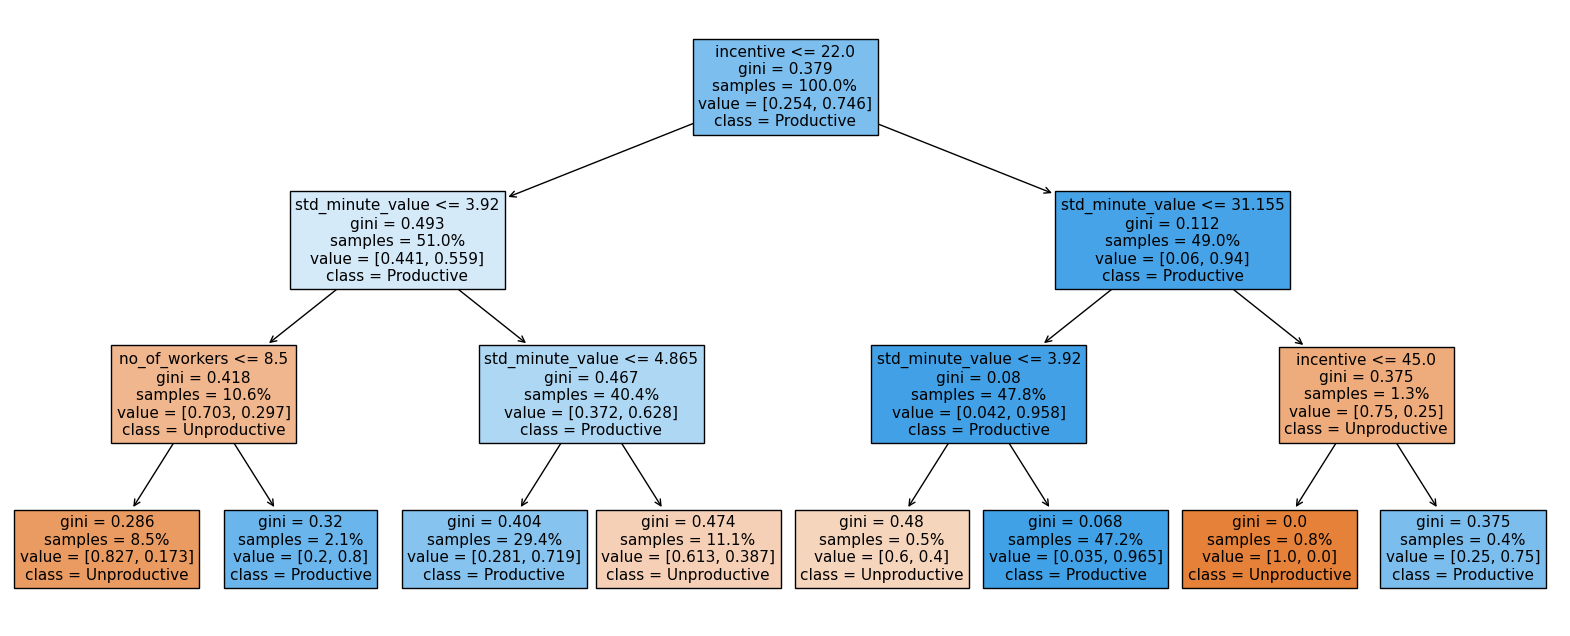

In [62]:
# Setting plot size

plt.figure(figsize = [20.0, 8.0])

# Plotting the tree with some specific parameters

_ = plot_tree(tree, 
              feature_names = list(X.columns), 
              class_names = ["Unproductive", "Productive"],
              filled = True, 
              rounded = False, 
              proportion = True, 
              fontsize = 11) 

Our model seems to have come to the conclusion that the most important features are incentive and standard minute value. Keep in mind that if we hadn't restricted the model into having only 3 branches, we would've seen other columns being used as well.


### Example scenarios

The best way to explain what we're looking at is to give an example scenario.

Let's assume that there is an observation  which has an "incentive" of 24 and a "standard minute value" of 5. Would our model predict that the productivity goal of the day is going to be reached?

The beauty of decision tree models is that one doesn't need coding experience to answer such questions. All we have to do is to follow the tree branches. 

Since the "incentive" is greater than 22, "24 <= 22" evaluates to False at the root node and so we follow the path to the right (**False splits always go to the right.**). Since the "standard minute value" is less than 31.155, "5 <= 31.155" evaluates to True at the child node below the root and so we follow the path to the left (**True splits always go to the left.**). In the final split, since the "standard minute value" is greater than 3.92, "5 <= 3.92" evaluates to False and so we follow the path to the right where we reach the final node, which has a "Productive" class.)

Let's try another scenario. This time, incentive will be 24.0 and standard minute value will be 3.0. The incentive is again greater than 22, so ""incentive <= 22.0" evaluates to false, we'll thus continue to the right. The standard minute value being 3.0 makes "std_minute_value <= 31.155" true, so we'll continue to the left. This time, our condition is "std_minute_value <= 3.92" and our scenario makes it true again. We continue left again and end up with an "Unproductive" class. From our tree, we can see that 0.5% of the samples shares these truth conditions and ends up here.

## Quality of the Model

Let's check out other metrics to see how well our model predicts the target data. We'll first create a confusion matrix to keep it as reference.

In [63]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[ 35,  24],
       [ 13, 168]], dtype=int64)

[[True Negatives, False Positives],

[False Negatives, True Positives]]

The confusion matrix shows the true and false positives and negatives. True is when the model predicts correctly that the value is positive or negative, and false is the opposite, where the model predicts something to be positive-negative but it is in fact the other option.

In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score

### Precision

Precision, or positive productive value (PPV) is calculated as follows:

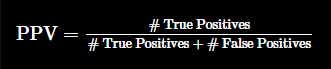

In [65]:
print("Precision:", round(precision_score(y_test, y_pred), 2) * 100, "%")

Precision: 88.0 %


### Recall

Recall, or negative predictive value (NPV) is calculated the same way as precision, but for negative values.

In [66]:
print("Recall:", round(recall_score(y_test, y_pred), 2) * 100, "%")

Recall: 93.0 %


### F1 Score

The F-score or F-measure is calculated from the precision and recall of the model.

In [67]:
print("F1 Score:", round(f1_score(y_test, y_pred), 2) * 100, "%")

F1 Score: 90.0 %


All of these metrics are even better than accuracy!

## Conclusion

We received data from a garment business, cleaned the said data and created a decision tree to predict whether an instance will be from a day when the productivity goal is reached or not. From our tests, we saw that the accuracy of our model is quite good. We hypothesized certain features for imaginary days and ran them through our tree to see if they would be productive or non-productive days.

## Decisions made in the data cleaning

### Data Cleaning 1: Exploration and basic cleaning

In [68]:
file = file_original.copy()
file.shape

(1197, 15)

In [69]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

There seems to be some missing values in wip column that we may need to fix. For now, let's check out the unique values in certain columns.

In [70]:
temp_list = ["quarter","department","day","team","targeted_productivity","no_of_style_change"]
for column in temp_list:
    print(file[column].value_counts())
    print("\n")

quarter
Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: count, dtype: int64


department
sweing        691
finishing     257
finishing     249
Name: count, dtype: int64


day
Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: count, dtype: int64


team
8     109
2     109
1     105
4     105
9     104
10    100
12     99
7      96
3      95
6      94
5      93
11     88
Name: count, dtype: int64


targeted_productivity
0.80    540
0.70    242
0.75    216
0.65     63
0.60     57
0.50     49
0.35     27
0.40      2
0.07      1
Name: count, dtype: int64


no_of_style_change
0    1050
1     114
2      33
Name: count, dtype: int64




We see that department column has two values for "finishing", one with a trailing space. Let's fix that.

In [71]:
file.loc[file["department"] == "finishing ", "department"] = "finishing"
file["department"].value_counts()

department
sweing       691
finishing    506
Name: count, dtype: int64

"quarter" column doesn't correspond to quarters of a year like one would think; it corresponds to quarters of a month.

In [72]:
file["quarter"].value_counts()

quarter
Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: count, dtype: int64

In [73]:
file[file["quarter"] == "Quarter5"]["date"].value_counts()

date
1/31/2015    24
1/29/2015    20
Name: count, dtype: int64

We see that Quarter5 only refers to 31st and 29th. So, it makes sense to include them in Quarter4 instead of keeping it a seperate column.

In [74]:
file.loc[file["quarter"] == "Quarter5", "quarter"] = "Quarter4"
file["quarter"].value_counts()

quarter
Quarter1    360
Quarter2    335
Quarter4    292
Quarter3    210
Name: count, dtype: int64

### Data Cleaning 2: Creating a new target column


The dataset is suitable for both regression and classification algorithms. We'll be using classification and because of that, we need our target column to be categorical. To accomplish this, we will create a new column called "productive". It will feature boolean values indicating if the productivity targets were achieved for each observation in the dataset..

In [75]:
file["productive"] = file["actual_productivity"] >= file["targeted_productivity"]
file.sample(10, random_state = 10)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,productive
123,1/7/2015,Quarter1,finishing,Wednesday,6,0.80,2.90,NaN,1800,0,0.0,0,0,10.0,0.666515,False
1117,3/8/2015,Quarter2,sweing,Sunday,11,0.80,11.41,313.0,3420,50,0.0,0,0,58.0,0.800035,True
508,1/29/2015,Quarter4,sweing,Thursday,1,0.75,22.94,1579.0,6960,81,0.0,0,0,58.0,0.850362,True
491,1/28/2015,Quarter4,finishing,Wednesday,8,0.65,4.15,NaN,960,0,0.0,0,0,8.0,0.553333,False
807,2/17/2015,Quarter3,sweing,Tuesday,12,0.80,15.26,1133.0,4080,38,0.0,0,0,34.0,0.800402,True
507,1/29/2015,Quarter4,finishing,Thursday,1,0.75,3.94,NaN,1200,0,0.0,0,0,10.0,0.853667,True
482,1/28/2015,Quarter4,sweing,Wednesday,10,0.80,22.52,1175.0,6720,60,0.0,0,0,56.0,0.850532,True
67,1/5/2015,Quarter1,finishing,Monday,2,0.80,3.94,NaN,960,0,0.0,0,0,8.0,0.804417,True
378,1/22/2015,Quarter4,sweing,Thursday,3,0.70,22.52,1244.0,10260,63,0.0,0,0,57.0,0.750068,True
264,1/15/2015,Quarter3,sweing,Thursday,1,0.80,26.16,1160.0,10620,75,0.0,0,0,59.0,0.850502,True


We'll remove the columns that are redundant/not useful in a tree model. In the end, here are the colums that we'll work with:

In [76]:
file = file[["quarter", "day", "department", "team", "no_of_workers", "targeted_productivity", 
        "actual_productivity", "productive", "over_time", "smv", "incentive"]]
file.head()

,quarter,day,department,team,no_of_workers,targeted_productivity,actual_productivity,productive,over_time,smv,incentive
0,Quarter1,Thursday,sweing,8,59.0,0.80,0.940725,True,7080,26.16,98
1,Quarter1,Thursday,finishing,1,8.0,0.75,0.886500,True,960,3.94,0
2,Quarter1,Thursday,sweing,11,30.5,0.80,0.800570,True,3660,11.41,50
3,Quarter1,Thursday,sweing,12,30.5,0.80,0.800570,True,3660,11.41,50
4,Quarter1,Thursday,sweing,6,56.0,0.80,0.800382,True,1920,25.90,50


We will now apply categorical encoding to the "department" column, turn the values into boolean and rename the column.

In [77]:
file["department"].replace({"finishing": 0, "sweing": 1}, inplace = True)
file.rename(columns = {"department": "dept_sweing"}, inplace = True)

C:\Users\ETERNALPUPPY\AppData\Local\Temp\ipykernel_18892\1682488573.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  file["department"].replace({"finishing": 0, "sweing": 1}, inplace = True)
C:\Users\ETERNALPUPPY\AppData\Local\Temp\ipykernel_18892\1682488573.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasti

### Data Cleaning 3: Dummy Columns

For the "quarter" column, we will use "dummies". Since they are categories instead of ordinal values, every category must have its own column, and the boolean process that we described for the previous column applies here.

The following code creates the dummies and also removes the original "quarter" column. The prefix parameter adds a "q_" prefix to all columns, so we can easily identify which ones are the dummies. Hence, the result will be to add four new columns to our dataset: "q_1", "q_2", "q_3" and "q_4".

In [78]:
file.head()

,quarter,day,dept_sweing,team,no_of_workers,targeted_productivity,actual_productivity,productive,over_time,smv,incentive
0,Quarter1,Thursday,1,8,59.0,0.80,0.940725,True,7080,26.16,98
1,Quarter1,Thursday,0,1,8.0,0.75,0.886500,True,960,3.94,0
2,Quarter1,Thursday,1,11,30.5,0.80,0.800570,True,3660,11.41,50
3,Quarter1,Thursday,1,12,30.5,0.80,0.800570,True,3660,11.41,50
4,Quarter1,Thursday,1,6,56.0,0.80,0.800382,True,1920,25.90,50


In [79]:
file = pd.concat([file, pd.get_dummies(file["quarter"], prefix = "q")], axis = 1).drop(["quarter"], axis = 1)
file.sample(5, random_state = 10)

,day,dept_sweing,team,no_of_workers,targeted_productivity,actual_productivity,productive,over_time,smv,incentive,q_Quarter1,q_Quarter2,q_Quarter3,q_Quarter4
123,Wednesday,0,6,10.0,0.80,0.666515,False,1800,2.90,0,True,False,False,False
1117,Sunday,1,11,58.0,0.80,0.800035,True,3420,11.41,50,False,True,False,False
508,Thursday,1,1,58.0,0.75,0.850362,True,6960,22.94,81,False,False,False,True
491,Wednesday,0,8,8.0,0.65,0.553333,False,960,4.15,0,False,False,False,True
807,Tuesday,1,12,34.0,0.80,0.800402,True,4080,15.26,38,False,False,True,False


Let's now repeat this process for the "day" column. Remember that for this one there are no "Friday" observations.

In [80]:
file = pd.concat([file, pd.get_dummies(file["day"], prefix= None)], axis=1).drop(["day"], axis=1)
file.sample(5, random_state = 10)

,dept_sweing,team,no_of_workers,targeted_productivity,actual_productivity,productive,over_time,smv,incentive,q_Quarter1,q_Quarter2,q_Quarter3,q_Quarter4,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
123,0,6,10.0,0.80,0.666515,False,1800,2.90,0,True,False,False,False,False,False,False,False,False,True
1117,1,11,58.0,0.80,0.800035,True,3420,11.41,50,False,True,False,False,False,False,True,False,False,False
508,1,1,58.0,0.75,0.850362,True,6960,22.94,81,False,False,False,True,False,False,False,True,False,False
491,0,8,8.0,0.65,0.553333,False,960,4.15,0,False,False,False,True,False,False,False,False,False,True
807,1,12,34.0,0.80,0.800402,True,4080,15.26,38,False,False,True,False,False,False,False,False,True,False


The "team" column will also receive the same treatment and we'll have 12 new columns.

In [81]:
file = pd.concat([file, pd.get_dummies(file["team"], prefix= "team")], axis=1).drop(["team"], axis=1)
file.sample(5, random_state = 10)

,dept_sweing,no_of_workers,targeted_productivity,actual_productivity,productive,over_time,smv,incentive,q_Quarter1,q_Quarter2,...,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
123,0,10.0,0.80,0.666515,False,1800,2.90,0,True,False,...,False,False,False,True,False,False,False,False,False,False
1117,1,58.0,0.80,0.800035,True,3420,11.41,50,False,True,...,False,False,False,False,False,False,False,False,True,False
508,1,58.0,0.75,0.850362,True,6960,22.94,81,False,False,...,False,False,False,False,False,False,False,False,False,False
491,0,8.0,0.65,0.553333,False,960,4.15,0,False,False,...,False,False,False,False,False,True,False,False,False,False
807,1,34.0,0.80,0.800402,True,4080,15.26,38,False,False,...,False,False,False,False,False,False,False,False,False,True


### Final Dataset

Below is the the dataset that the algorithm sees in the end.

In [82]:
file.head()

,dept_sweing,no_of_workers,targeted_productivity,actual_productivity,productive,over_time,smv,incentive,q_Quarter1,q_Quarter2,...,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
0,1,59.0,0.80,0.940725,True,7080,26.16,98,True,False,...,False,False,False,False,False,True,False,False,False,False
1,0,8.0,0.75,0.886500,True,960,3.94,0,True,False,...,False,False,False,False,False,False,False,False,False,False
2,1,30.5,0.80,0.800570,True,3660,11.41,50,True,False,...,False,False,False,False,False,False,False,False,True,False
3,1,30.5,0.80,0.800570,True,3660,11.41,50,True,False,...,False,False,False,False,False,False,False,False,False,True
4,1,56.0,0.80,0.800382,True,1920,25.90,50,True,False,...,False,False,False,True,False,False,False,False,False,False


Here are all the column names:

In [83]:
file.columns

Index(['dept_sweing', 'no_of_workers', 'targeted_productivity',
       'actual_productivity', 'productive', 'over_time', 'smv', 'incentive',
       'q_Quarter1', 'q_Quarter2', 'q_Quarter3', 'q_Quarter4', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'team_1',
       'team_2', 'team_3', 'team_4', 'team_5', 'team_6', 'team_7', 'team_8',
       'team_9', 'team_10', 'team_11', 'team_12'],
      dtype='object')

**Thanks for reading!**